# Percolating Small Changes to Initial Conditions

This notebook describes and runs an experiment where two different initial global states are initialized and the resulting series are compared with each other.

The intended use of this notebook is for one variable to be tweaked between the global states for a particular time step to then compare the resulting series to the series of the original global state.

Author: Akhil Karra
```{contents}
```

## Prerequisites

This notebook uses the OpenAI API to chat with GPT models for each LLM-powered agent. This requires a `.env` file in the root directory of the `agentomics` repository to load the `OPENAI_API_KEY`. Make sure the `.env` file is present in the root directory of the repository and includes the keys before running the notebook.

In [ ]:
import contextlib
import re

import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv
from IPython.display import HTML, display
from langroid.utils.configuration import Settings, set_global

from agentomics.common.data_structures import ThreeBankGlobalState
from agentomics.common.types import NonnegPercent, Percent
from scripts.economic_simulations.three_banks import simulate_two_way

load_dotenv()

# Additional notebook-specific constants; please reset as desired.
CONTROL_CSV_PATH = "./percolate_deltas_control_output.csv"
EXP_CSV_PATH = "./percolate_deltas_exp_output.csv"
MODEL_NAME = "gpt-4o-mini"

## Set Inputs

Please set the inputs to the simulations here. This includes the control series for the simulation as well as what changes are desired for the experimental series.

In [ ]:
# Control series

# Economic variables
gdp_growth_rate_control = list(map(Percent, [0.0405, 0.0458, 0.0293, 0.0424, 0.0453]))
unemployment_rate_control = list(map(NonnegPercent, [0.0489, 0.0593, 0.0352, 0.0582, 0.0693]))
inflation_rate_control = list(map(Percent, [0.021, 0.0177, 0.0236, 0.0251, 0.0122]))

# Central bank knobs
target_interest_rate_control = list(map(NonnegPercent, [0.0105, 0.0194, 0.0084, 0.0078, 0.012]))
securities_holdings_pc_change_control = list(map(Percent, [0.008, 0.0104, 0.0012, 0.0015, 0.0314]))

# Big bank knobs
loan_to_deposit_ratio_control = list(map(NonnegPercent, [0.7631, 0.5886, 0.6443, 0.7557, 0.66]))
deposit_interest_rate_control = list(map(NonnegPercent, [0.0109, 0.0106, 0.0136, 0.002, 0.0033]))

# Small bank knobs
loans_interest_rate_control = list(map(NonnegPercent, [0.0552, 0.0453, 0.0326, 0.0343, 0.0533]))
consumer_loan_focus_control = list(map(NonnegPercent, [0.1113, 0.2546, 0.4927, 0.2236, 0.1566]))

# Number of rounds to simulate
simulation_rounds = 5

In [ ]:
# Experimental series

# Initialize the series to be copies of the control series
gdp_exp = gdp_growth_rate_control.copy()
unemployment_exp = unemployment_rate_control.copy()
inflation_exp = inflation_rate_control.copy()
target_interest_rate_exp = target_interest_rate_control.copy()
securities_holdings_pc_change_exp = securities_holdings_pc_change_control.copy()
loan_to_deposit_ratio_exp = loan_to_deposit_ratio_control.copy()
deposit_interest_rate_exp = deposit_interest_rate_control.copy()
loans_interest_rate_exp = loans_interest_rate_control.copy()
consumer_loan_focus_exp = consumer_loan_focus_control.copy()

# Make any small changes you would like to these parameters below
target_interest_rate_exp[-1] = NonnegPercent(target_interest_rate_exp[-1] + NonnegPercent(0.01))  # 1% Increase in Target Inflation Rate

## Run Experiment

### Create Global States for Simulation
This includes the control global state and the experimental global state.

In [ ]:
globals_control = ThreeBankGlobalState()
globals_control.economic_variables.gdp_growth_rate.set_array(gdp_growth_rate_control)
globals_control.economic_variables.unemployment_rate.set_array(unemployment_rate_control)
globals_control.economic_variables.inflation_rate.set_array(inflation_rate_control)
globals_control.central_bank_knobs.target_interest_rate.set_array(target_interest_rate_control)
globals_control.central_bank_knobs.securities_holdings_pc_change.set_array(securities_holdings_pc_change_control)
globals_control.big_bank_knobs.loan_to_deposit_ratio.set_array(loan_to_deposit_ratio_control)
globals_control.big_bank_knobs.deposit_interest_rate.set_array(deposit_interest_rate_control)
globals_control.small_bank_knobs.loans_interest_rate.set_array(loans_interest_rate_control)
globals_control.small_bank_knobs.consumer_loan_focus.set_array(consumer_loan_focus_control)
globals_control.number_of_quarters_to_simulate = simulation_rounds

In [ ]:
globals_exp = ThreeBankGlobalState()
globals_exp.economic_variables.gdp_growth_rate.set_array(gdp_exp)
globals_exp.economic_variables.unemployment_rate.set_array(unemployment_exp)
globals_exp.economic_variables.inflation_rate.set_array(inflation_exp)
globals_exp.central_bank_knobs.target_interest_rate.set_array(target_interest_rate_exp)
globals_exp.central_bank_knobs.securities_holdings_pc_change.set_array(securities_holdings_pc_change_exp)
globals_exp.big_bank_knobs.loan_to_deposit_ratio.set_array(loan_to_deposit_ratio_exp)
globals_exp.big_bank_knobs.deposit_interest_rate.set_array(deposit_interest_rate_exp)
globals_exp.small_bank_knobs.loans_interest_rate.set_array(loans_interest_rate_exp)
globals_exp.small_bank_knobs.consumer_loan_focus.set_array(consumer_loan_focus_exp)
globals_exp.number_of_quarters_to_simulate = simulation_rounds

### Run Simulation

In [ ]:
%%capture

log_file_path = "./simulation_output.log"

# Open the log file in write mode
with open(log_file_path, "w") as log_file:
    # Redirect both stdout and stderr to the log file
    with contextlib.redirect_stdout(log_file), contextlib.redirect_stderr(log_file):
        set_global(Settings(notebook=True))
        simulate_two_way(globals_control, MODEL_NAME, outfile=CONTROL_CSV_PATH)
        simulate_two_way(globals_exp, MODEL_NAME, outfile=EXP_CSV_PATH)

2024-12-08 23:06:51 - WARNING - REDIS_PASSWORD, REDIS_HOST, REDIS_PORT not set in .env file,
                        using fake redis client


### Clean Up and Print Simulation Logs
Here we use a regular expressions matcher to remove the color coding in logs. We use some custom HTML code that we inject into the notebook to print the log as a collapsible section.

In [ ]:
# Read the contents of the log file into a string
with open(log_file_path, "r") as log_file:
    log_contents = log_file.read()

# HTML for collapsible section
clean_output = re.sub(r"\x1B(?:[@-Z\\-_]|\[[0-?]*[ -/]*[@-~])|\[\d+m", "", log_contents)

collapsible_html = f"""
<div>
    <button onclick="this.nextElementSibling.style.display =
    (this.nextElementSibling.style.display === 'none') ? 'block' : 'none';">
        Show/Hide Text Output
    </button>
    <div style="display: none; margin-top: 10px;">
        <pre style="white-space: pre-wrap; font-family: inherit;">{clean_output}</pre>
    </div>
</div>
"""

# Display the collapsible section
display(HTML(collapsible_html))

### Save Global States

In [ ]:
globals_control_df = globals_control.to_pandas_df()
globals_exp_df = globals_exp.to_pandas_df()
globals_control_df.to_csv(CONTROL_CSV_PATH)
globals_exp_df.to_csv(EXP_CSV_PATH)

### Read Global States

If the simulation(s) terminate early, you can start from this cell onwards to load the data that was generated upto the point of failure and graph this data to gather at least some analysis.

In [ ]:
# If the simulations terminate early, you can still run this cell onwards to
# graph the data that was collected upto the point of termination
globals_control_df = pd.read_csv(CONTROL_CSV_PATH)
globals_exp_df = pd.read_csv(EXP_CSV_PATH)

### Plot Control vs Experimental Values

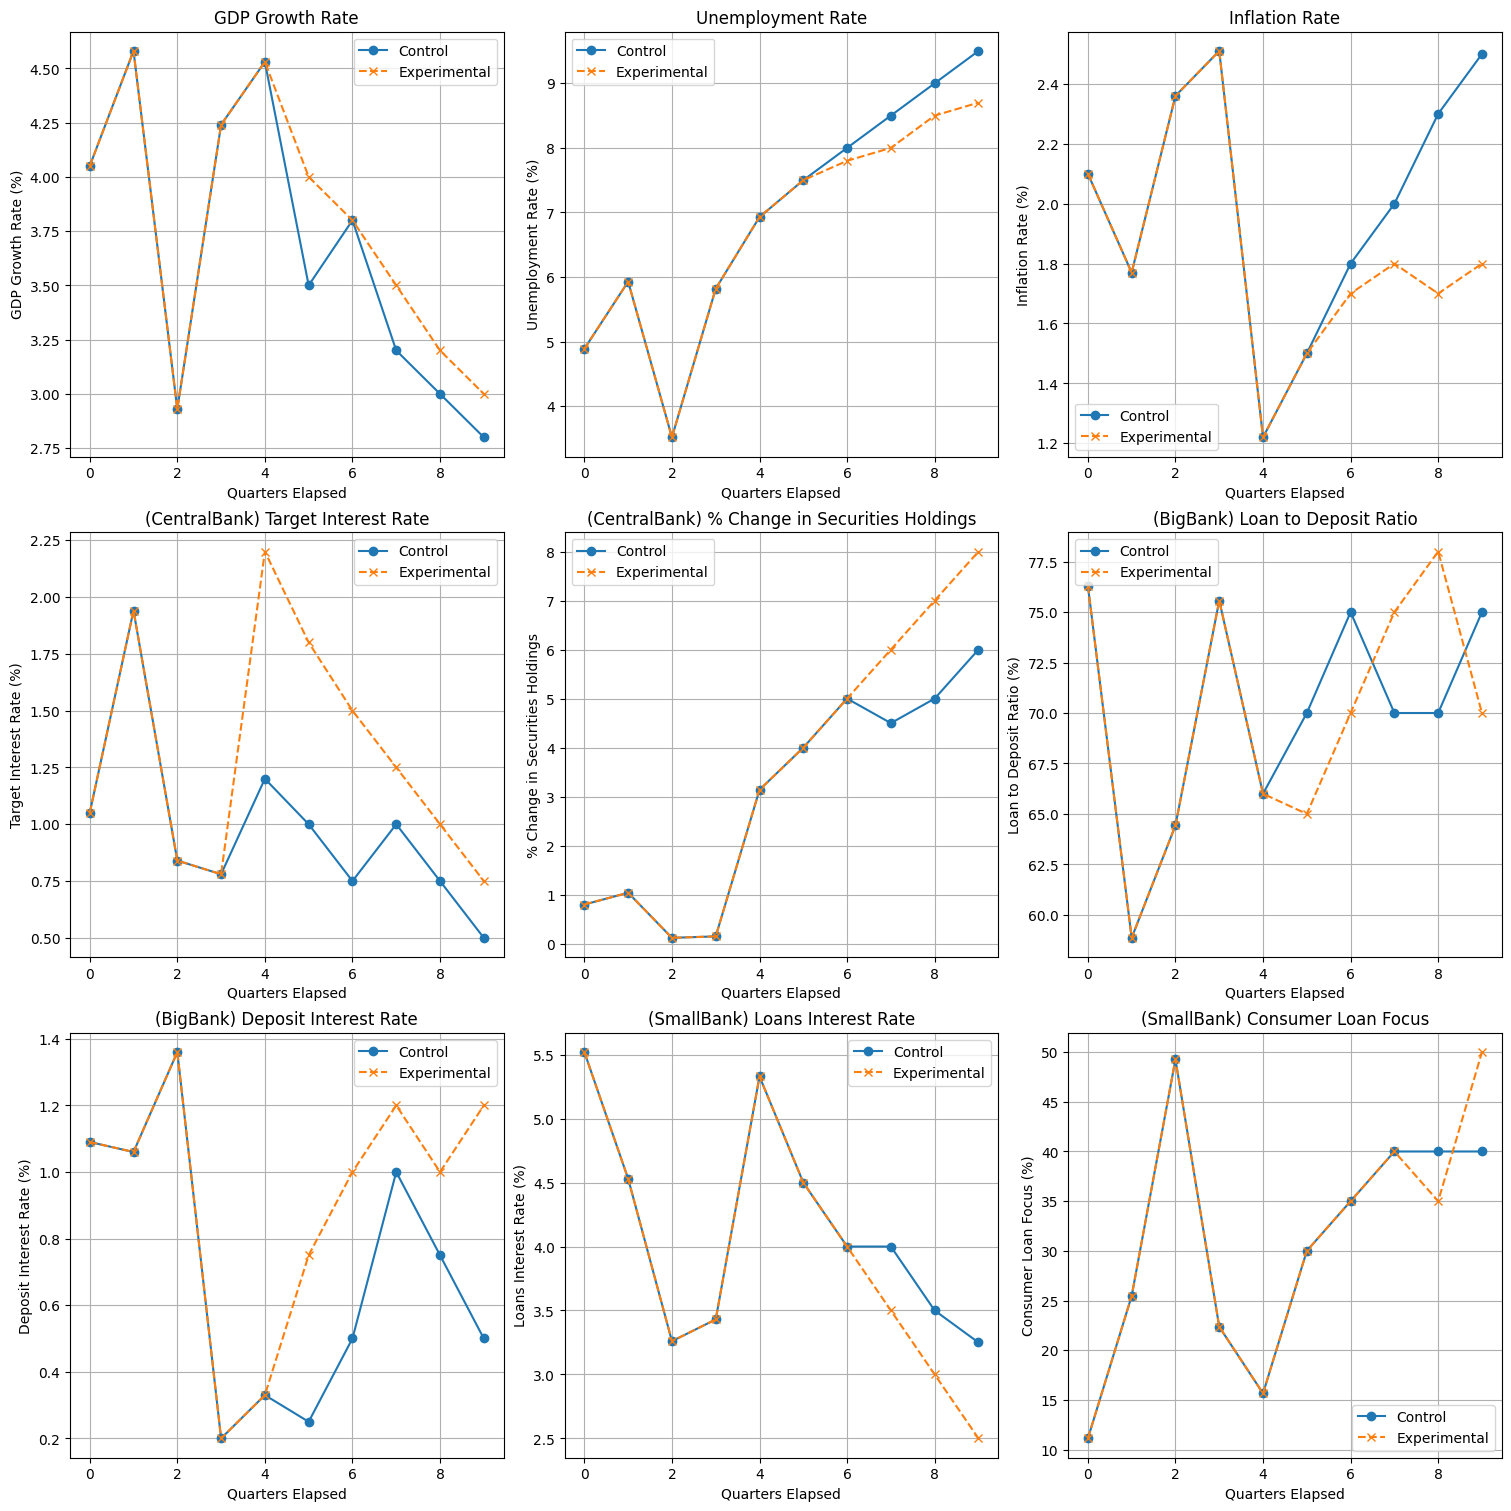

In [ ]:
titles = {
    "gdp_growth_rate": "GDP Growth Rate",
    "unemployment_rate": "Unemployment Rate",
    "inflation_rate": "Inflation Rate",
    "target_interest_rate": "(CentralBank) Target Interest Rate",
    "total_securities_holdings": "(CentralBank) % Change in Securities Holdings",
    "loan_to_deposit_ratio": "(BigBank) Loan to Deposit Ratio",
    "deposit_interest_rate": "(BigBank) Deposit Interest Rate",
    "loans_interest_rate": "(SmallBank) Loans Interest Rate",
    "consumer_loan_focus": "(SmallBank) Consumer Loan Focus"
}

ylabels = {
    "gdp_growth_rate": "GDP Growth Rate (%)",
    "unemployment_rate": "Unemployment Rate (%)",
    "inflation_rate": "Inflation Rate (%)",
    "target_interest_rate": "Target Interest Rate (%)",
    "total_securities_holdings": "% Change in Securities Holdings",
    "loan_to_deposit_ratio": "Loan to Deposit Ratio (%)",
    "deposit_interest_rate": "Deposit Interest Rate (%)",
    "loans_interest_rate": "Loans Interest Rate (%)",
    "consumer_loan_focus": "Consumer Loan Focus (%)"
}

# List of columns to plot
columns = globals_control_df.columns[1:]

# Determine the layout of subplots (e.g., 3 rows, 3 columns for 9 plots)
n_cols = 3
n_rows = -(-len(columns) // n_cols)  # Ceiling division to determine rows

# Create the figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), constrained_layout=True)
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Plot each column in a separate subplot
for i, col in enumerate(columns):
    ax = axes[i]
    ax.plot(globals_control_df[col] * 100.0, label="Control", marker="o", linestyle="-")
    ax.plot(globals_exp_df[col] * 100.0, label="Experimental", marker="x", linestyle="--")
    ax.set_title(titles[col])
    ax.set_xlabel("Quarters Elapsed")
    ax.set_ylabel(ylabels[col])
    ax.legend()
    ax.grid(True)

# Turn off any extra subplots if the number of plots is less than n_rows * n_cols
for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

# Show the plots
plt.show()